<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220913.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [18]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
from datetime import datetime, time, timezone, timedelta, date
import os
import re

from functools import reduce
from collections import defaultdict, ChainMap, Counter

# customer analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'test.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'sample_data']

In [3]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.columns = ['_'.join(re.split('(?=[A-Z][a-z])', a[0].lower()+a[1:])).lower() for a in df.columns]
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df = df[(~df.invoice_no.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]
df.invoice_date = pd.to_datetime(df.invoice_date)
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.unit_price
df = df.rename(columns = {'customerid':'id'}).groupby(['id','date','week','month', 'stock_code'])['rev'].sum().reset_index()
df.head()

,id,date,week,month,stock_code,rev
0,12346.0,2011-01-18,2011-01-17,2011-01-01,23166,77183.60
1,12747.0,2010-12-05,2010-11-29,2010-12-01,21136,13.52
2,12747.0,2010-12-05,2010-11-29,2010-12-01,82484,199.80
3,12747.0,2010-12-05,2010-11-29,2010-12-01,84879,27.04
4,12747.0,2010-12-05,2010-11-29,2010-12-01,85062,39.60


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342273 entries, 0 to 342272
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          342273 non-null  float64       
 1   date        342273 non-null  datetime64[ns]
 2   week        342273 non-null  datetime64[ns]
 3   month       342273 non-null  datetime64[ns]
 4   stock_code  342273 non-null  object        
 5   rev         342273 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(1)
memory usage: 15.7+ MB


In [12]:
list_npu = df.groupby(['id','stock_code'])['date'].min().reset_index().rename(columns = {'date':'npu_date'})
df_ = pd.merge(df, list_npu, 'left', ['id', 'stock_code'])
df_ = df_.assign(days = (df_['date'] - df_['npu_date']).dt.days)
df_.head()

,id,date,week,month,stock_code,rev,npu_date,days
0,12346.0,2011-01-18,2011-01-17,2011-01-01,23166,77183.60,2011-01-18,0
1,12747.0,2010-12-05,2010-11-29,2010-12-01,21136,13.52,2010-12-05,0
2,12747.0,2010-12-05,2010-11-29,2010-12-01,82484,199.80,2010-12-05,0
3,12747.0,2010-12-05,2010-11-29,2010-12-01,84879,27.04,2010-12-05,0
4,12747.0,2010-12-05,2010-11-29,2010-12-01,85062,39.60,2010-12-05,0


In [13]:
cnt = df_.groupby(['stock_code', 'days'])['id'].count().reset_index().rename(columns = {'id':'pu'})
cnt['ratio'] = cnt.groupby(['stock_code'])['pu'].apply(lambda x : round(x/x.max()*100,2))
cnt = pd.melt(cnt, id_vars = ['stock_code','days'], var_name = 'type')
cnt.head()

,stock_code,days,type,value
0,10002,0,pu,30.0
1,10002,7,pu,1.0
2,10002,42,pu,1.0
3,10002,49,pu,1.0
4,10002,97,pu,1.0


In [16]:
cnt['stock_code'].value_counts()

85123A    662
85099B    634
84879     572
22423     554
22197     546
         ... 
84801A      2
84801B      2
84802A      2
84802B      2
23417       2
Name: stock_code, Length: 3645, dtype: int64

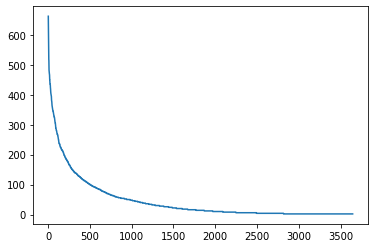

In [19]:
plt.plot(range(1,3646), cnt['stock_code'].value_counts())

In [40]:
list_cnt = cnt['stock_code'].value_counts().reset_index()
list_cnt.head()
list_cnt['ratio'] = round(list_cnt['stock_code']/list_cnt['stock_code'].sum()*100, 2)
list_cnt = list_cnt[list_cnt.ratio >= 0.3]
list_cnt = list_cnt.rename(columns = {'index':'stock_code', 'stock_code':'cnt'})
list_cnt.head()

,stock_code,cnt,ratio
0,85123A,662,0.40
1,85099B,634,0.38
2,84879,572,0.34
3,22423,554,0.33
4,22197,546,0.33


,stock_code,days,type,value
3042,20725,0,pu,454.00
3043,20725,5,pu,2.00
3044,20725,7,pu,3.00
3045,20725,9,pu,1.00
3046,20725,10,pu,2.00
...,...,...,...,...
165537,85123A,361,ratio,0.24
165538,85123A,363,ratio,0.12
165539,85123A,365,ratio,0.24
165540,85123A,370,ratio,0.12


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


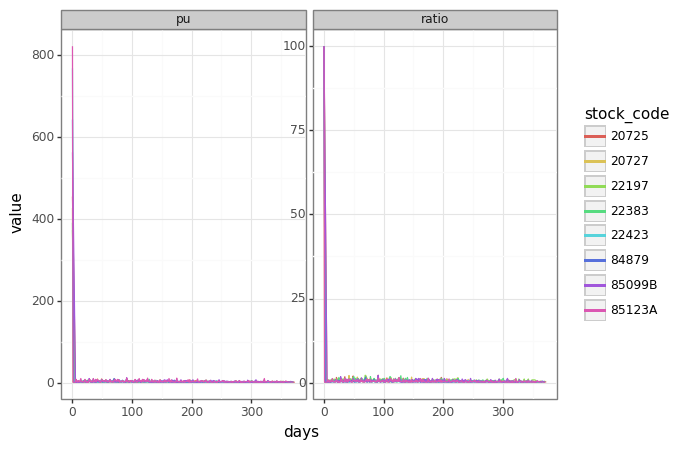

<ggplot: (8794438155017)>

In [43]:
(
    ggplot(cnt[cnt['stock_code'].isin(list_cnt['stock_code'])], aes('days','value', color = 'stock_code')) +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw() 
)

# iterator

In [44]:
mat = [list('ABC'), list('DEF'), list('GHI')]
[(r, c, letters) for r, rows in enumerate(mat) for c, letters in enumerate(rows)]

[(0, 0, 'A'),
 (0, 1, 'B'),
 (0, 2, 'C'),
 (1, 0, 'D'),
 (1, 1, 'E'),
 (1, 2, 'F'),
 (2, 0, 'G'),
 (2, 1, 'H'),
 (2, 2, 'I')]

In [45]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [50]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [53]:
def add_title_with_name(name) :
  def add_title(func) :
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper
  return add_title 

def add_title(func) :
  def wrapper(*args, **kwargs) :
    return 'park' + '\n' + func(*args, **kwargs)
  return wrapper

@add_title_with_name('kim')
def get_title(title) :
  return title

@add_title
def get_title2(t1, t2) : 
  return t1 + '\n' + t2

In [54]:
print(get_title('그런 것도 몰랐다는 걸'))
print(get_title2('아무 것도 넌 모르잖아', '나를 차갑게 돌아 서도'))

kim
그런 것도 몰랐다는 걸
park
아무 것도 넌 모르잖아
나를 차갑게 돌아 서도
